<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/QuantumToyAlgorithm_QFT_02_GoogleAIStudio_mkbahk_20250423.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-h3smmjlh
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/qiskit-textbook.git /tmp/pip-req-build-h3smmjlh
  Resolved https://github.com/qiskit-community/qiskit-textbook.git to commit 0ae905083ec3872d7ddc6bb4001d5468f476d93f
  Preparing metadata (setup.py) ... done


In [64]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex
from qiskit_aer import Aer
from IPython.display import display, Math
import numpy as np
#import matplotlib.pyplot as plt

In [65]:
from qiskit.circuit.library import QFT       # Qiskit의 내장 QFT 클래스

In [81]:
# --- 코드 설명 (1) ---
# numpy: 수학 계산, 특히 복소수 및 배열 작업에 사용될 수 있습니다 (여기서는 직접 사용하지 않지만 일반적).
# QuantumCircuit: 양자 회로를 생성하고 조작하는 데 사용되는 핵심 클래스입니다.
# transpile: 양자 회로를 특정 백엔드(시뮬레이터 또는 실제 하드웨어)에 맞게 최적화하고 변환합니다.
# AerSimulator: Qiskit Aer 패키지에서 제공하는 고성능 시뮬레이터 백엔드 중 하나입니다. 상태 벡터, 유니터리, 측정 결과(qasm) 시뮬레이션 등을 지원합니다.
# plot_histogram: 측정 결과를 히스토그램으로 시각화하는 함수입니다.
# QFT: Qiskit 라이브러리에 미리 구현된 QFT 회로를 쉽게 생성할 수 있는 클래스입니다.
# ----------------------

# 2. 시뮬레이션 파라미터 설정
n_qubits = 9  # 사용할 큐빗 수 (상태 |001>는 3큐빗 필요)
shots = 1024  # 시뮬레이션 반복 횟수 (측정 통계 얻기 위함)

# --- 코드 설명 (2) ---
# n_qubits: 문제에서 주어진 입력 상태 |001>가 3개의 큐빗으로 표현되므로 3으로 설정합니다.
# shots: qasm_simulator는 실제 양자 컴퓨터처럼 확률적인 측정을 시뮬레이션합니다.
#        여러 번(shots) 실행하여 각 측정 결과의 빈도수(counts)를 통계적으로 얻습니다.
#        샷 수가 많을수록 이론적인 확률 분포에 더 가깝게 수렴합니다.
# ----------------------

In [82]:
# 3. 양자 회로 생성
# n_qubits개의 양자 비트와 n_qubits개의 고전 비트(측정 결과 저장용)로 회로를 초기화합니다.
circuit = QuantumCircuit(n_qubits, n_qubits, name="QFT for |001>")

# --- 코드 설명 (3) ---
# QuantumCircuit(n_qubits, n_qubits): 첫 번째 인수는 양자 레지스터의 크기(큐빗 수),
#                                    두 번째 인수는 고전 레지스터의 크기(측정 결과를 저장할 비트 수)입니다.
#                                    QFT 후 모든 큐빗을 측정할 것이므로 같은 크기로 설정합니다.
# name="...": 회로에 이름을 지정하여 나중에 식별하기 쉽게 합니다.
# ----------------------

# 4. 입력 상태 |001> 준비
# Qiskit에서 큐빗은 |0> 상태로 초기화됩니다. |000> -> |001>로 만들기 위해
# 가장 낮은 인덱스(q0)의 큐빗에 X 게이트(NOT 게이트)를 적용합니다.
# Qiskit의 큐빗 인덱싱: q2, q1, q0 순서. 따라서 q0를 뒤집습니다.
circuit.x(0)
circuit.barrier() # 시각적 구분을 위해 배리어 추가

# --- 코드 설명 (4) ---
# circuit.x(0): 큐빗 0에 Pauli-X 게이트를 적용합니다. X|0> = |1>.
#              따라서 회로의 초기 상태 |000>가 |001> 상태로 변경됩니다.
#              (Qiskit에서 q0는 가장 오른쪽, 즉 가장 낮은 유효 비트에 해당)
# circuit.barrier(): 회로 다이어그램에서 로직 단계를 시각적으로 분리하는 역할을 합니다.
#                   실제 계산에는 영향을 주지 않습니다. 입력 준비 단계와 QFT 단계를 구분합니다.
# ----------------------

# 5. QFT 적용
# Qiskit의 내장 QFT 클래스를 사용하여 QFT 회로 객체를 생성합니다.
# num_qubits: QFT를 적용할 큐빗 수
# approximation_degree: QFT 근사 정도 (0은 정확한 QFT)
# do_swaps: QFT 정의에 따라 마지막에 필요한 SWAP 게이트들을 포함할지 여부 (True가 표준)
# inverse: False로 설정하여 정방향 QFT 수행
# insert_barriers: QFT 내부 단계 사이에 배리어를 삽입할지 여부
qft_gate = QFT(num_qubits=n_qubits, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=True, name='qft')

# 생성된 QFT 게이트를 회로의 모든 큐빗(0부터 n_qubits-1까지)에 적용합니다.
circuit.append(qft_gate, range(n_qubits))
circuit.barrier() # 시각적 구분을 위해 배리어 추가

# --- 코드 설명 (5) ---
# qft_gate = QFT(...): QFT 회로를 나타내는 객체를 생성합니다.
#    - num_qubits=n_qubits: 3큐빗 QFT를 생성합니다.
#    - do_swaps=True: QFT 알고리즘은 일반적으로 마지막에 큐빗 순서를 뒤집는 SWAP 연산이 필요합니다.
#                     이 옵션을 True로 설정하면 Qiskit이 자동으로 SWAP 게이트들을 포함시켜 줍니다.
#                     이것이 표준적인 QFT 정의에 해당합니다.
# circuit.append(qft_gate, range(n_qubits)): 생성된 qft_gate 객체를 회로에 추가합니다.
#                                            range(n_qubits)는 [0, 1, 2]를 의미하며,
#                                            QFT를 0번, 1번, 2번 큐빗에 적용하라는 뜻입니다.
# ----------------------

# 6. 모든 큐빗 측정
# 양자 상태를 고전 정보로 변환하기 위해 모든 큐빗을 측정합니다.
# q_i를 c_i에 매핑합니다 (qubit i의 측정 결과를 classical bit i에 저장).
circuit.measure(range(n_qubits), range(n_qubits))

# --- 코드 설명 (6) ---
# circuit.measure(range(n_qubits), range(n_qubits)):
#    - 첫 번째 range(n_qubits)는 측정할 양자 비트의 인덱스 리스트 [0, 1, 2]입니다.
#    - 두 번째 range(n_qubits)는 측정 결과를 저장할 고전 비트의 인덱스 리스트 [0, 1, 2]입니다.
#    - 즉, 큐빗 0 -> 고전 비트 0, 큐빗 1 -> 고전 비트 1, 큐빗 2 -> 고전 비트 2로 측정 결과가 저장됩니다.
# ----------------------

# 7. 회로 시각화 (선택 사항)
print("Quantum Circuit Diagram:")
print(circuit.draw(output='text')) # 텍스트 기반 회로도 출력
# circuit.draw(output='mpl') # Matplotlib을 사용한 그래픽 회로도 (GUI 환경 필요)

# --- 코드 설명 (7) ---
# circuit.draw(...): 생성된 양자 회로를 시각적으로 표현합니다.
#    - output='text': 콘솔에 출력할 수 있는 텍스트 기반 다이어그램을 생성합니다.
#    - output='mpl': Matplotlib 라이브러리를 사용하여 더 보기 좋은 그래픽 이미지를 생성합니다.
#                   (주피터 노트북이나 GUI 환경에서 유용)
# ----------------------


Quantum Circuit Diagram:
     ┌───┐ ░ ┌──────┐ ░ ┌─┐                        
q_0: ┤ X ├─░─┤0     ├─░─┤M├────────────────────────
     └───┘ ░ │      │ ░ └╥┘┌─┐                     
q_1: ──────░─┤1     ├─░──╫─┤M├─────────────────────
           ░ │      │ ░  ║ └╥┘┌─┐                  
q_2: ──────░─┤2     ├─░──╫──╫─┤M├──────────────────
           ░ │      │ ░  ║  ║ └╥┘┌─┐               
q_3: ──────░─┤3     ├─░──╫──╫──╫─┤M├───────────────
           ░ │      │ ░  ║  ║  ║ └╥┘┌─┐            
q_4: ──────░─┤4 qft ├─░──╫──╫──╫──╫─┤M├────────────
           ░ │      │ ░  ║  ║  ║  ║ └╥┘┌─┐         
q_5: ──────░─┤5     ├─░──╫──╫──╫──╫──╫─┤M├─────────
           ░ │      │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐      
q_6: ──────░─┤6     ├─░──╫──╫──╫──╫──╫──╫─┤M├──────
           ░ │      │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
q_7: ──────░─┤7     ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├───
           ░ │      │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_8: ──────░─┤8     ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
           ░ └──────┘ ░  ║  ║  ║  ║  ║ 

In [83]:
# 8. Aer 시뮬레이터 설정 및 실행
simulator = Aer.get_backend("qasm_simulator") # 기본 Aer 시뮬레이터 인스턴스 생성 (qasm_simulator가 기본 중 하나)

# 회로를 시뮬레이터에 맞게 트랜스파일합니다 (이 단계는 간단한 시뮬레이션에서는 생략 가능).
compiled_circuit = transpile(circuit, simulator)

# 시뮬레이터를 사용하여 회로를 실행합니다.
job = simulator.run(compiled_circuit, shots=shots)

# 시뮬레이션 결과 가져오기
result = job.result()

# 측정 결과(counts) 추출
counts = result.get_counts(compiled_circuit)

# --- 코드 설명 (8) ---
# simulator = AerSimulator(): 시뮬레이션을 수행할 백엔드를 선택합니다. AerSimulator는 여러 시뮬레이션
#                           메소드(statevector, qasm 등)를 지원합니다. 측정 결과를 얻으려면
#                           내부적으로 'qasm_simulator' 방식이 사용됩니다.
# compiled_circuit = transpile(...): 실제 하드웨어나 특정 시뮬레이터의 제약 조건에 맞게 회로를
#                                  최적화하고 변환하는 과정입니다. 간단한 시뮬레이션에서는
#                                  필수적이지 않지만, 좋은 습관입니다.
# job = simulator.run(...): 지정된 회로(compiled_circuit)를 설정된 샷(shots)만큼 시뮬레이터에서 실행합니다.
#                          이 작업은 비동기적으로 실행될 수 있으며, job 객체를 반환합니다.
# result = job.result(): 시뮬레이션 작업이 완료될 때까지 기다린 후 결과 객체를 가져옵니다.
# counts = result.get_counts(...): 결과 객체에서 측정된 고전 비트 상태와 그 빈도수를 담은
#                                 딕셔너리를 추출합니다. 키는 측정된 비트 문자열(예: '001', '101'),
#                                 값은 해당 상태가 측정된 횟수입니다.
#                                 Qiskit의 counts 딕셔너리 키는 'q_n-1 ... q1 q0' 순서의 문자열입니다.
#                                 예: '101'은 q2=1, q1=0, q0=1을 의미합니다.
# ----------------------


In [84]:
# 9. 결과 출력 및 시각화
print(f"\nInput state: |001> ({n_qubits} qubits)")
print(f"Number of shots: {shots}")
print("\nMeasurement Results (Counts):")
print(counts)


Input state: |001> (9 qubits)
Number of shots: 1024

Measurement Results (Counts):
{'101000111': 1, '000111011': 1, '001010101': 1, '111010100': 1, '101101000': 1, '110001000': 1, '101001011': 1, '101100110': 2, '000010011': 1, '110011011': 1, '000011000': 1, '001000101': 1, '101100000': 3, '100000001': 3, '111101111': 2, '100001111': 1, '001100101': 3, '010101001': 2, '000111001': 1, '001011111': 1, '010111000': 1, '111111011': 1, '010100011': 2, '000000101': 1, '101110110': 1, '111111110': 2, '111010001': 1, '000010110': 2, '000010111': 1, '010101010': 1, '111101101': 1, '101001110': 1, '010001011': 1, '000111111': 2, '111001101': 1, '010111100': 1, '110100001': 2, '110111111': 1, '011011011': 2, '110110011': 1, '000001100': 1, '110000001': 4, '000011101': 2, '100111111': 1, '010011100': 2, '111000100': 3, '110010100': 1, '101001101': 1, '011110000': 1, '111101010': 2, '111010000': 2, '011100110': 2, '001101111': 1, '010010100': 1, '010110010': 1, '110010010': 1, '011000111': 1, '11

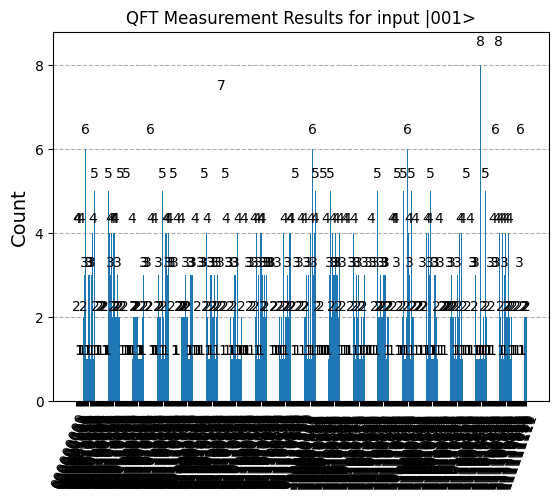

In [85]:
# 결과 히스토그램 그리기
plot_histogram(counts, title='QFT Measurement Results for input |001>')

# --- 코드 설명 (9) ---
# print(...): 시뮬레이션 설정 정보와 최종 측정 결과(counts 딕셔너리)를 콘솔에 출력합니다.
# plot_histogram(counts, ...): 측정 결과(counts)를 막대 그래프 형태의 히스토그램으로 시각화합니다.
#                             x축은 측정된 상태(비트 문자열), y축은 해당 상태의 측정 빈도수입니다.
#                             이론적으로 QFT(|001>)는 모든 상태가 동일한 확률(1/8)로 측정되므로,
#                             히스토그램의 모든 막대 높이가 비슷하게 나타날 것으로 예상됩니다 (샷 수에 따른 통계적 변동은 있음).
# ----------------------
